In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import montecarlo_localization as mcl
%load_ext autoreload
%autoreload 2
#%matplotlib inline

# Monte Carlo localization

This notebook presents a demonstration of Erik Sjoberg's implementation of Monte Carlo localization (particle filter) on a dataset of 2d laser scans

## Example laser scan data

Note the legs of a person which appear in the dataset; this dynamic obstacle will increase the difficulty of the localization.

<img  src="data/robotmovie1.gif"/>

## Corresponding relative odometry log data

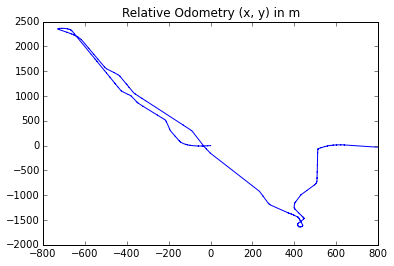

In [29]:
logdata = mcl.load_log('data/log/robotdata2.log.gz')
logdata['x_rel'] = logdata['x'] - logdata.ix[0,'x']
logdata['y_rel'] = logdata['y'] - logdata.ix[0,'y']
plt.plot(logdata['x_rel'], logdata['y_rel'])
plt.title('Relative Odometry (x, y) in m')

Note the significant drift in the path according to the odometry data above, which should have returned to it's initial position

## Map to localize within

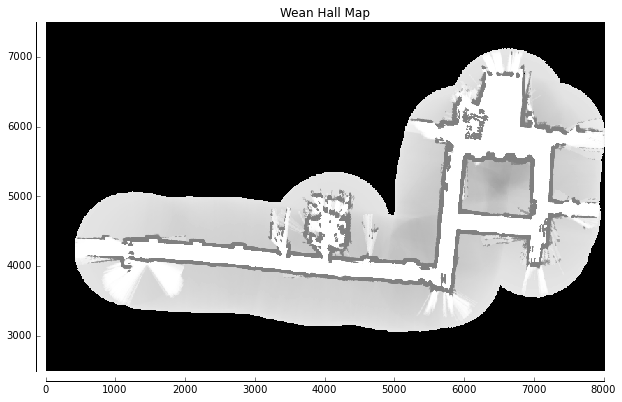

In [9]:
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
mcl.draw_map_state(global_map, rotate=True)

## Initialize valid particles uniformly on map

Particles are initialized uniformy over the entire 8000cm x 8000cm area with random heading, but are re-sampled if they end up in a grid cell which is not clear with high confidence (map value > 0.8).

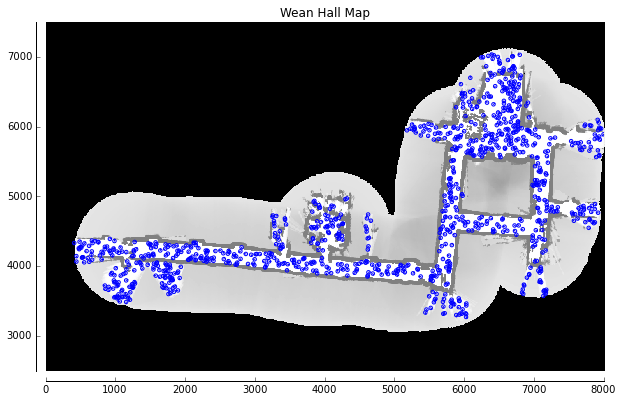

In [10]:
sensor = mcl.laser_sensor()  # Defines sensor measurement model
particle_list = [mcl.robot_particle(global_map, sensor)
                 for _ in range(1000)]
mcl.draw_map_state(global_map, particle_list, rotate=True)
plt.show()

# Localization Program Execution

In [2]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, dpi=400, fps=10, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

In [2]:
class ParticleMap(object):
    def __init__(self, ax, global_map, particle_list, target_particles=300,  draw_max=2000, resample_period=10):
        self.ax = ax
        self.draw_max = draw_max
        self.global_map = global_map
        self.particle_list = particle_list
        mcl.draw_map_state(global_map, particle_list, ax=self.ax, draw_max=self.draw_max)
        self.i = 1
        self.target_particles = target_particles
        self.resample_period = resample_period

    def update(self, message):
        if self.i % self.resample_period == 0:# Resample and plot state
            self.particle_list = mcl.mcl_update(self.particle_list, message, resample=True,
                                                target_particles=self.target_particles) # Update
            plt.cla()        
            mcl.draw_map_state(self.global_map, self.particle_list, self.ax, draw_max=self.draw_max)
            #print(pd.Series([p.weight for p in self.particle_list]).describe())
        else: # Just update particle weights / locations - do not resample
            self.particle_list = mcl.mcl_update(self.particle_list, message, 
                                                target_particles=self.target_particles) # Update
        self.i += 1

In [6]:
import matplotlib.animation as animation
import matplotlib.animation as animation
np.random.seed(5)
wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
logdata = mcl.load_log('data/log/robotdata5.log.gz')
logdata_scans = logdata.query('type > 0.1').values

#Initialize 100 particles uniformly in valid locations on the map
laser = mcl.laser_sensor(stdv_cm=100, uniform_weight=0.2)
particle_list = [mcl.robot_particle(wean_hall_map, laser, log_prob_descale=2000,
                                    sigma_fwd_pct=0.2, sigma_theta_pct=0.1)
                 for _ in range(50000)]

fig, ax = plt.subplots(figsize=(16,9))

pmap = ParticleMap(ax, wean_hall_map, particle_list,
                   target_particles=300, draw_max=2000, resample_period=10)

# pass a generator in "emitter" to produce data for the update func
ani = animation.FuncAnimation(fig, pmap.update, logdata_scans, interval=50,
                              blit=False, repeat=False)

ani.save('./mcl_log5_50k_success.mp4'.format(i), dpi=100, fps=10, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
plt.close('all')
#plt.show()
#anim_to_html(ani)

In [ ]:
plt.close('all')

In [65]:
mcl.mp4_to_html('./mcl_log1_50k_success.mp4'):

### View log data

In [7]:
logdata = mcl.load_log('data/log/robotdata1.log.gz')
logdata['x_rel'] = logdata['x'] - logdata.ix[0,'x']
logdata['y_rel'] = logdata['y'] - logdata.ix[0,'y']
plt.plot(logdata['x_rel'], logdata['y_rel'])

In [8]:

logdata['theta_rel'] = logdata['theta'] - logdata.ix[0,'theta']
logdata['xl_rel'] = logdata['xl'] - logdata.ix[0,'xl']
logdata['yl_rel'] = logdata['yl'] - logdata.ix[0,'yl']
logdata['thetal_rel'] = logdata['thetal'] - logdata.ix[0,'thetal']

In [9]:
logdata['dt'] = logdata['ts'].shift(-1) - logdata['ts']
logdata['dx'] = logdata['x'].shift(-1) - logdata['x']
logdata['dy'] = logdata['y'].shift(-1) - logdata['y']
logdata['dtheta'] = logdata['theta'].shift(-1) - logdata['theta']
logdata['dxl'] = logdata['xl'].shift(-1) - logdata['xl']
logdata['dyl'] = logdata['yl'].shift(-1) - logdata['yl']
logdata['dthetal'] = logdata['thetal'].shift(-1) - logdata['thetal']

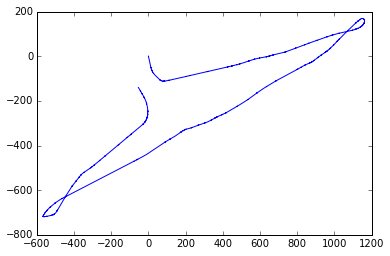